In [98]:
#Faz a ligação com o banco de dados do Google
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [99]:
import numpy as np 
import pandas as pd 
from scipy.stats import ttest_ind, ttest_rel
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [100]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Aprendizado estatístico/adult.csv',encoding='UTF-8',sep=',', header=0)
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


### VERIFICANDO OS DADOS

In [101]:
#Identificando os nomes das colunas
print('Colunas: ',df.columns,'\n')

#Identificando a quantidade de linhas e colunas do dataframe
linhas=df.shape[0]
colunas=df.shape[1]

print('Número de Linhas:', linhas)
print('Número de Colunas:', colunas)

Colunas:  Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object') 

Número de Linhas: 32561
Número de Colunas: 15


### LIMPANDO OS DADOS

In [102]:
print('=================================================')
for coluna in df.columns:
  print('Coluna: ', coluna)
  print(np.unique(df[coluna], return_counts = True)[0])
  print('=================================================')

Coluna:  age
[17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88
 90]
Coluna:  workclass
['?' 'Federal-gov' 'Local-gov' 'Never-worked' 'Private' 'Self-emp-inc'
 'Self-emp-not-inc' 'State-gov' 'Without-pay']
Coluna:  fnlwgt
[  12285   13769   14878 ... 1366120 1455435 1484705]
Coluna:  education
['10th' '11th' '12th' '1st-4th' '5th-6th' '7th-8th' '9th' 'Assoc-acdm'
 'Assoc-voc' 'Bachelors' 'Doctorate' 'HS-grad' 'Masters' 'Preschool'
 'Prof-school' 'Some-college']
Coluna:  education.num
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Coluna:  marital.status
['Divorced' 'Married-AF-spouse' 'Married-civ-spouse'
 'Married-spouse-absent' 'Never-married' 'Separated' 'Widowed']
Coluna:  occupation
['?' 'Adm-clerical' 'Armed-Forces' 'Craft-repair' 'Exec-managerial'
 'Farming-fishing' 'Handlers-cleaners' 'Machine-op-inspct' 'Othe

Note que as colunas workclass, occupation, native.country contém valores marcados com '?', estes valores devem ser substituidos. Já as linhas com dados sem informação serão eliminadas.


In [103]:
#A coluna 'education.num' é apenas uma represetação numérica da coluna 'education' e será eliminada para evitar 
#termos 2 colunas representando a mesma informação.
df = df.drop(["education.num"], axis=1)

#Remove as linhas com dados sem informação do dataframe
df = df[(df['occupation'] != '?')]
df = df[df['native.country'] != '?']
df = df[(df['workclass'] != '?')]

#Substituindo os valores do target
df['income']=df['income'].map({'<=50K':0,'>50K':1})

#A coluna 'income' é o target, logo deve ser eliminada do dataframe principal
target=df["income"]
df = df.drop(["income"], axis=1)

### ANÁLISE ESTATÍSTICA DOS DADOS

In [104]:
#Análise estatística dos features numéricos
df.describe()

,age,fnlwgt,capital.gain,capital.loss,hours.per.week
count,30162.000000,3.016200e+04,30162.000000,30162.000000,30162.000000
mean,38.437902,1.897938e+05,1092.007858,88.372489,40.931238
std,13.134665,1.056530e+05,7406.346497,404.298370,11.979984
min,17.000000,1.376900e+04,0.000000,0.000000,1.000000
25%,28.000000,1.176272e+05,0.000000,0.000000,40.000000
50%,37.000000,1.784250e+05,0.000000,0.000000,40.000000
75%,47.000000,2.376285e+05,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,99999.000000,4356.000000,99.000000


In [105]:
#Análise estatística dos features em formato textual
df.describe(include=["O"])

,workclass,education,marital.status,occupation,relationship,race,sex,native.country
count,30162,30162,30162,30162,30162,30162,30162,30162
unique,7,16,7,14,6,5,2,41
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
freq,22286,9840,14065,4038,12463,25933,20380,27504


In [106]:
#Identificando quais são as features mais estatisticamente relevantes
import scipy.stats as stats
def teste_qui_quadrado(coluna, target):
    observed=pd.crosstab(coluna,target)
    p_valor=stats.chi2_contingency(observed)[1]
    return(p_valor)

def features_relevantes(dataframe, target):
  colunas=dataframe.columns.tolist()
  #category
  alpha=0.01
  count=0
  features=[]
  for coluna in colunas:
      p_valor=teste_qui_quadrado(dataframe[coluna], target)
      if p_valor<=alpha:
          count+=1
          features.append(coluna)
          print(coluna,' possui uma relação com o target')
          print('p-valor para ',coluna,' é ', p_valor,'\n')
      else:
          print(coluna,' não possui uma relação com o target')
          print('p-valor para ',coluna,' é ', p_valor,'\n')
  print('Número total de features no dataframe analisado:',len(colunas))
  print('Numero de features que contribuem:', count, '\n')
  print(features)
  return features
  
features_relevantes=features_relevantes(df, target)

age  possui uma relação com o target
p-valor para  age  é  0.0 

workclass  possui uma relação com o target
p-valor para  workclass  é  1.946095589239045e-170 

fnlwgt  possui uma relação com o target
p-valor para  fnlwgt  é  3.3827785104320154e-06 

education  possui uma relação com o target
p-valor para  education  é  0.0 

marital.status  possui uma relação com o target
p-valor para  marital.status  é  0.0 

occupation  possui uma relação com o target
p-valor para  occupation  é  0.0 

relationship  possui uma relação com o target
p-valor para  relationship  é  0.0 

race  possui uma relação com o target
p-valor para  race  é  1.3178285203762715e-64 

sex  possui uma relação com o target
p-valor para  sex  é  1.00155254124934e-309 

capital.gain  possui uma relação com o target
p-valor para  capital.gain  é  0.0 

capital.loss  possui uma relação com o target
p-valor para  capital.loss  é  0.0 

hours.per.week  possui uma relação com o target
p-valor para  hours.per.week  é  0.0 

n

In [107]:
#Agora que sabemos as features relevantes, vamos filtrar no dataframe principal
df=df[features_relevantes]
df.head()

,age,workclass,fnlwgt,education,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
1,82,Private,132870,HS-grad,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States
3,54,Private,140359,7th-8th,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States
4,41,Private,264663,Some-college,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States
5,34,Private,216864,HS-grad,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States
6,38,Private,150601,10th,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States


### KNN

In [108]:
#Conventendo as variáveis categóricas
df_novo=pd.get_dummies(df)

In [109]:
#Gerando os dados de treino e teste
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_novo,target,test_size=0.3,random_state=30,stratify=target)

In [110]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler
#Ajusta as features
scaler = RobustScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)  
x_test = scaler.transform(x_test)

In [111]:
#As avaliações dos classificadores será realizada através da função abaixo
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix,accuracy_score
def avalia_classificador(clf,x_test,y_test):
    predictions = clf.predict(x_test)
    print('Precision report:\nprecision \t\t\t recall \t\t\t f-score \t\t\t support\n',
          precision_recall_fscore_support(y_test, predictions)[0],'\t',
          precision_recall_fscore_support(y_test, predictions)[1],
          '\t',precision_recall_fscore_support(y_test, predictions)[2],'\t',
          precision_recall_fscore_support(y_test, predictions)[3],'\n')
    print('Confusion matrix:\n',confusion_matrix(y_test, predictions),'\n')
    print('Accuracy score:',accuracy_score(y_test, predictions)*100,'\n')

In [112]:
def curva_roc(clf, x_test, y_test):
  import matplotlib.pyplot as plt
  from sklearn.metrics import plot_roc_curve
  plot_roc_curve(clf, x_test, y_test)
  plt.show()

1 - 0.8241794673444579
2 - 0.8371090728257266
3 - 0.8348988838545696
4 - 0.8460603381589126
5 - 0.8442921869819869
6 - 0.8491546027185324
7 - 0.850259697204111
Melhor tamanho de vizinhança: 7
Melhor score: 0.850259697204111
Precision report:
precision 			 recall 			 f-score 			 support
 [0.88827055 0.71974522] 	 [0.91584523 0.65230906] 	 [0.90184716 0.6843699 ] 	 [6797 2252] 

Confusion matrix:
 [[6225  572]
 [ 783 1469]] 

Accuracy score: 85.0259697204111 

Acurácia com cross validation: 0.8518453624009549


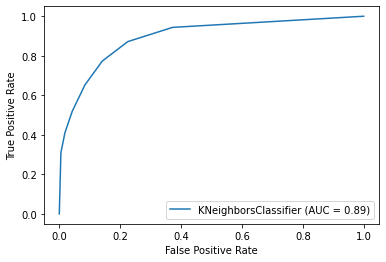

In [113]:
score=np.zeros(shape=(8,2))
melhor_tamanho_vizinhanca=0
melhor_pontuacao=0

for tamanho_vizinhanca in range(1,8):
    knn = KNeighborsClassifier(n_neighbors=tamanho_vizinhanca)
    knn.fit(x_train,y_train)
    pontuacao=knn.score(x_test,y_test)
    score[tamanho_vizinhanca-1][0]=tamanho_vizinhanca
    score[tamanho_vizinhanca-1][1]=pontuacao
    if pontuacao>melhor_pontuacao:
      melhor_pontuacao=pontuacao
      melhor_tamanho_vizinhanca=tamanho_vizinhanca
    print(tamanho_vizinhanca,'-', pontuacao)
print('Melhor tamanho de vizinhança:',tamanho_vizinhanca)
print('Melhor score:', melhor_pontuacao)

#Treinando com o melhor tamanho de vizinhança
clf = KNeighborsClassifier(n_neighbors=melhor_tamanho_vizinhanca)
clf.fit(x_train,y_train)
avalia_classificador(clf,x_test,y_test)
score = cross_val_score(clf, x_train, y_train, cv = 5, scoring="accuracy")
print("Acurácia com cross validation:", score.mean())
curva_roc(clf, x_test, y_test)

### Random Forest

Precision report:
precision 			 recall 			 f-score 			 support
 [0.8796103  0.74409871] 	 [0.92982198 0.61589698] 	 [0.90401945 0.6739553 ] 	 [6797 2252] 

Confusion matrix:
 [[6320  477]
 [ 865 1387]] 

Accuracy score: 85.1696320035363 

Acurácia com cross validation: 0.8512295068635105


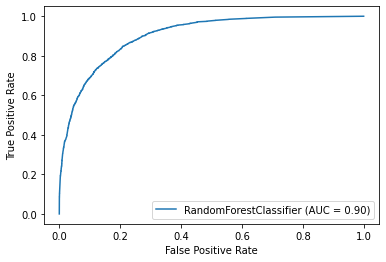

In [117]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(max_depth=40, random_state=30)

# Train the model using the training sets
clf.fit(x_train,y_train)

avalia_classificador(clf,x_test,y_test)
score = cross_val_score(clf, x_train, y_train, cv = 5, scoring="accuracy")
print("Acurácia com cross validation:", score.mean())
curva_roc(clf, x_test, y_test)

### Multilayer Perceptron



Precision report:
precision 			 recall 			 f-score 			 support
 [0.87487916 0.74446903] 	 [0.93202884 0.59769094] 	 [0.90255022 0.66305419] 	 [6797 2252] 

Confusion matrix:
 [[6335  462]
 [ 906 1346]] 

Accuracy score: 84.88230743728589 

Acurácia com cross validation: 0.8350305387036523


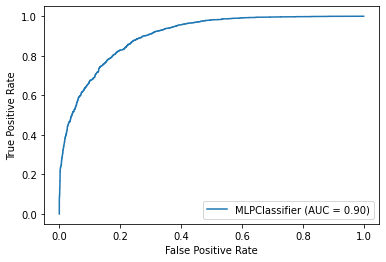

In [118]:
from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler


# Treinando o classificador Multilayer Perceptron
clf = MLPClassifier(hidden_layer_sizes=(10, 10, 10),max_iter=1000)  
clf.fit(x_train, y_train.values.ravel())

avalia_classificador(clf,x_test,y_test)
score = cross_val_score(clf, x_train, y_train, cv = 5, scoring="accuracy")
print("Acurácia com cross validation:", score.mean())
curva_roc(clf, x_test, y_test)